# report stats, monitor change

record properties of ``treedb.sqlite``
loaded from [Glottolog](https://glottolog.org)
[master repo](https://github.com/glottolog/glottolog) commit
and monitor changes by diffing this

<div style="text-align: right">
  <a href="https://nbviewer.jupyter.org/github/glottolog/treedb/blob/master/Stats.ipynb">
      latest version from GitHub in nbviewer
  </a>
</div>

### contents
1. [clone/checkout](#clone/checkout)
2. [load](#load)
3. [treedb.sqlite](#treedb.sqlite)
4. [\_\_dataset\_\_](#__dataset__)
5. [treedb.raw](#treedb.raw)
6. [languoid](#languoid)
7. [link](#link)
8. [denormalized](#denormalized)

In [1]:
%matplotlib inline

import collections
import datetime
import functools
import logging
import pathlib
import subprocess

from urllib.parse import urlparse  # PY3

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import treedb

from treedb import raw

FILE = treedb.FILE

REBUILD = False

ECHO = True

logging.basicConfig(format='%(message)s')
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

treedb.__version__

'0.1.dev0'

## clone/checkout

In [2]:
%%time

GLOTTOLOG, TAG = 'https://github.com/glottolog/glottolog.git', 'v4.0'

BRANCH = 'treedb'

TARGET = pathlib.Path('..',  'glottolog')

CLONE_DEPTH = 1

def checkout_if_needed(force=REBUILD, clone=True):
    if force or not FILE.exists():
        if not TARGET.exists():
            if not clone:
                raise RuntimeError
            subprocess.run(['git', 'clone',
                            '--branch', TAG,
                            '--depth', '%d' % CLONE_DEPTH,
                            GLOTTOLOG, str(TARGET)], check=True)
        return subprocess.run(['git', 'checkout',
                               '-B', BRANCH,
                               'tags/%s' % TAG], cwd=TARGET, check=True)
    return None

checkout_if_needed()

Wall time: 0 ns


## load

In [3]:
pathlib.PurePath(*treedb.ROOT.parts[-4:]).as_posix()

'../glottolog/languoids/tree'

In [4]:
next(treedb.iterfiles())

(('abin1243',), <DirEntry 'md.ini'>, <treedb.files.ConfigParser at 0x995b108>)

In [5]:
next(treedb.iterlanguoids())

{'id': 'abin1243',
 'parent_id': None,
 'level': 'language',
 'name': 'Abinomn',
 'hid': 'bsa',
 'iso639_3': 'bsa',
 'latitude': -2.92281,
 'longitude': 138.891,
 'macroareas': ['Papunesia'],
 'countries': [('Indonesia', 'ID')],
 'links': [{'url': 'http://endangeredlanguages.com/lang/1763',
   'title': 'Abinomn',
   'scheme': 'http'},
  {'url': 'http://www.wikidata.org/entity/Q56648',
   'title': None,
   'scheme': 'http'},
  {'url': 'https://en.wikipedia.org/wiki/Abinomn_language',
   'title': None,
   'scheme': 'https'}],
 'sources': {'glottolog': [{'bibfile': 'hh',
    'bibkey': 'e:Lagerberg:Moegip',
    'pages': None,
    'trigger': None},
   {'bibfile': 'hh',
    'bibkey': 'h:SilzerClouse:Index',
    'pages': None,
    'trigger': None},
   {'bibfile': 'hh',
    'bibkey': 'h:SilzerHeikkinen:Irian',
    'pages': None,
    'trigger': None},
   {'bibfile': 'hh',
    'bibkey': 'hv:Foley:Northwest-New-Guinea',
    'pages': None,
    'trigger': None},
   {'bibfile': 'hh',
    'bibkey': '

In [6]:
str(FILE)

'treedb.sqlite3'

In [7]:
str(treedb.load(rebuild=REBUILD, exclude_raw=False))

0:01:48.500206


'treedb.sqlite3'

In [8]:
MB = 2**20

FILE.stat().st_size / MB

97.5859375

In [9]:
treedb.tools.sha256sum(FILE).hexdigest()

'4a8e66ce11e0042b42a6a80913f31b210fead8be25f1e96588362e97075bd811'

In [10]:
str(datetime.datetime.fromtimestamp(FILE.stat().st_mtime))

'2019-07-31 23:36:49.473606'

In [11]:
treedb.check()

valid_glottocodeCheck: OK
valid_iso639_3Check: OK
valid_hidCheck: OK
clean_nameCheck: OK
family_parentCheck: OK
language_parentCheck: OK
dialect_parentCheck: OK
family_childrenCheck: OK
family_languagesCheck: OK
bookkeeping_no_childrenCheck: OK
no_empty_filesCheck: OK


In [12]:
%%time
#treedb.compare_with_raw()

Wall time: 0 ns


## treedb.sqlite

In [13]:
if ECHO:
    logging.getLogger('sqlalchemy.engine').setLevel(logging.INFO)

text = functools.partial(sa.text, bind=treedb.engine)
select = functools.partial(sa.select, bind=treedb.engine)
count = sa.func.count
read_sql = functools.partial(pd.read_sql_query, con=treedb.engine)

treedb.engine

Engine(sqlite:///treedb.sqlite3)

In [14]:
select([sa.func.sqlite_version()]).scalar()

SELECT sqlite_version() AS sqlite_version_1
()


'3.28.0'

In [15]:
application_id = text('PRAGMA application_id').scalar()

assert application_id == 1122 == 0x462
assert application_id == sum(ord(c) for c in treedb.Dataset.__tablename__)
assert treedb.Dataset.__tablename__ == '__dataset__'

application_id

PRAGMA application_id
()


1122

In [16]:
sqlite_master = sa.table('sqlite_master', *map(sa.column, ['name', 'type', 'sql']))

table_name = sqlite_master.c.name.label('table_name')

select_tables = select([table_name])\
    .where(sqlite_master.c.type == 'table')\
    .where(~table_name.like('sqlite_%'))\
    .order_by(table_name)

select_sql = select([sqlite_master.c.sql])\
    .where(sqlite_master.c.type == 'table')\
    .where(table_name == sa.bindparam('table_name'))

def print_sql(model):
    print(select_sql.scalar(table_name=model.__tablename__))
    label = 'n_%ss' % model.__name__.lower()
    print(select([count().label(label)]).select_from(model).scalar())
    
select_tables_nrows = ((sa.literal(t).label('table_name'),
                        select([count()]).select_from(sa.table(t)).label('n_rows'))
                       for t, in select_tables.execute())
select_tables_nrows = sa.union_all(*map(select, select_tables_nrows))
    
read_sql(select_tables_nrows, index_col='table_name')

SELECT sqlite_master.name AS table_name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY table_name
('table', 'sqlite_%')
SELECT ? AS table_name, (SELECT count(*) AS count_1 
FROM __dataset__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_2 
FROM _file) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_3 
FROM _option) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_4 
FROM _value) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_5 
FROM altname) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_6 
FROM classificationcomment) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_7 
FROM classificationref) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_8 
FROM country) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS count_9 
FROM endangerment) AS n_rows UNION ALL SELECT ? AS table_nam

,n_rows
table_name,
__dataset__,1
_file,24438
_option,51
_value,595096
altname,140712
classificationcomment,11667
classificationref,15500
country,226
endangerment,7978


## \_\_dataset\_\_

In [17]:
Dataset = treedb.Dataset

print_sql(Dataset)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '__dataset__')
SELECT count(*) AS n_datasets 
FROM __dataset__
()


CREATE TABLE __dataset__ (
	id BOOLEAN DEFAULT (1) NOT NULL CHECK (id), 
	title TEXT NOT NULL CHECK (title != ''), 
	git_commit VARCHAR(40) NOT NULL CHECK (length(git_commit) = 40), 
	git_describe TEXT NOT NULL CHECK (git_describe != ''), 
	clean BOOLEAN NOT NULL, 
	exclude_raw BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	CHECK (id IN (0, 1)), 
	UNIQUE (git_commit), 
	UNIQUE (git_describe), 
	CHECK (clean IN (0, 1)), 
	CHECK (exclude_raw IN (0, 1))
)
1


In [18]:
dataset, = select([Dataset]).execute()

pd.DataFrame.from_dict(dataset, orient='index', columns=['__dataset__'])

SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.exclude_raw 
FROM __dataset__
()


,__dataset__
id,True
title,Glottolog treedb
git_commit,75c5f97b8a9f429f83b91134a097b1578f779429
git_describe,v4.0
clean,True
exclude_raw,False


## `treedb.raw`

In [19]:
File, Option, Value = raw_models = raw.File, raw.Option, raw.Value

for model in raw_models:
    print_sql(model)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_file')
SELECT count(*) AS n_files 
FROM _file
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_option')
SELECT count(*) AS n_options 
FROM _option
()
SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_value')
SELECT count(*) AS n_values 
FROM _value
()


CREATE TABLE _file (
	id INTEGER NOT NULL, 
	glottocode VARCHAR(8) NOT NULL CHECK (length(glottocode) = 8), 
	path TEXT NOT NULL CHECK (length(path) >= 8), 
	size INTEGER NOT NULL CHECK (size > 0), 
	sha256 VARCHAR(64) NOT NULL CHECK (length(sha256) = 64), 
	PRIMARY KEY (id), 
	CHECK (substr(path, -length(glottocode)) = glottocode), 
	UNIQUE (glottocode), 
	UNIQUE (path), 
	UNIQUE (sha256)
)
24438
CREATE TABLE _option (
	id INTEGER NOT NULL, 
	section TEXT NOT NULL CHECK (section != ''), 
	option TEXT NOT NULL CHECK (option != ''), 
	lines BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (section, option), 
	CHECK (lines IN (0, 1))
)
51
CREATE TABLE _value (
	file_id INTEGER NOT NULL, 
	option_id INTEGER NOT NULL, 
	line INTEGER NOT NULL CHECK (line >= 0), 
	value TEXT NOT NULL CHECK (value != ''), 
	PRIMARY KEY (file_id, option_id, line), 
	FOREIGN KEY(file_id) REFERENCES _file (id), 
	FOREIGN KEY(option_id) REFERENCES _option (id)
)
595096


In [20]:
read_sql(select([File]).limit(5), index_col='id')

SELECT _file.id, _file.glottocode, _file.path, _file.size, _file.sha256 
FROM _file
 LIMIT ? OFFSET ?
(5, 0)


,glottocode,path,size,sha256
id,,,,
1,abin1243,abin1243,1228,2121537058713210f4fdf8ab4cda3f19bb9a0cb7a6f1ab...
2,abis1238,abis1238,1790,f2745a5a5bb8a3752cdabe2ff53c9a75ab8eef1072035a...
3,abkh1242,abkh1242,305,19234c64f84b699d645508cfddc00f014dd857326747d9...
4,abkh1243,abkh1242/abkh1243,256,762db330191d90980e952424a90a5584bcfb733ffa65ef...
5,abaz1241,abkh1242/abkh1243/abaz1241,2412,cbf79b31086c058673709415657bb0070f7aa26ae875f9...


In [21]:
read_sql(select([Option]).limit(5), index_col='id')

SELECT _option.id, _option.section, _option.option, _option.lines 
FROM _option
 LIMIT ? OFFSET ?
(5, 0)


,section,option,lines
id,,,
1,core,name,False
2,core,hid,False
3,core,level,False
4,core,iso639-3,False
5,core,latitude,False


In [22]:
read_sql(select([Value]).limit(5), index_col=['file_id', 'option_id'])

SELECT _value.file_id, _value.option_id, _value.line, _value.value 
FROM _value
 LIMIT ? OFFSET ?
(5, 0)


line     value
file_id option_id                
1       1             0   Abinomn
        2             0       bsa
        3             0  language
        4             0       bsa
        5             0  -2.92281

In [23]:
select_file_values = select([
        Option.section, Option.option, Value.line, Value.value,
    ]).select_from(sa.join(File, Value).join(Option))\
    .where(File.glottocode == sa.bindparam('glottocode'))

read_sql(select_file_values, params={'glottocode': 'abin1243'},
         index_col=['section', 'option', 'line'])

SELECT _option.section, _option.option, _value.line, _value.value 
FROM _file JOIN _value ON _file.id = _value.file_id JOIN _option ON _option.id = _value.option_id 
WHERE _file.glottocode = ?
('abin1243',)


value
section        option              line                                                   
core           name                0                                               Abinomn
               hid                 0                                                   bsa
               level               0                                              language
               iso639-3            0                                                   bsa
               latitude            0                                              -2.92281
               longitude           0                                               138.891
               macroareas          1                                             Papunesia
               countries           1                                        Indonesia (ID)
               links               1     [Abinomn](http://endangeredlanguages.com/lang/...
                                   2                 http://www.wikidata.org/entity/Q56648
                                   3        https://en.wikipedia.org/wiki/Abinomn_language
sources        glottolog           1                             **hh:e:Lagerberg:Moegip**
                                   2                           **hh:h:SilzerClouse:Index**
                                   3                        **hh:h:SilzerHeikkinen:Irian**
                                   4                  **hh:hv:Foley:Northwest-New-Guinea**
                                   5                **hh:hvtyp:DonohueMusgrave:Melanesia**
                                   6                                **hh:w:Fiwei:Abinomn**
altnames       multitree           1                                                "Baso"
                                   2                                               Abinomn
                                   3                                              Avinomen
                                   4                                                  Foja
                                   5                                                  Foya
               lexvo               1                                          Abinomn [en]
                                   2                                 Abinomn language [en]
                                   3                                        Abinomneg [br]
                                   4                                   Lingua abinomn [gl]
                                   5                                 Llingua Abinomn [ast]
               hhbib_lgcode        1                                                  Baso
               elcat               1                                                "Baso"
                                   2                                               Abinomn
                                   3                                              Avinomen
                                   4                                                  Foja
                                   5                                                  Foya
triggers       lgcode              1                                          macrohistory
                                   2                                                moegip
identifier     multitree           0                                                   bsa
               endangeredlanguages 0                                                  1763
classification familyrefs          1                           **hh:h:SilzerClouse:Index**
                                   2                **hh:hvtyp:DonohueMusgrave:Melanesia**
endangerment   status              0                                              shifting
               source              0                                                 ElCat
               date                0                                   2017-08-19T08:16:16
               comment             0     Abinomn (1763-bsa) = Endangered (20 perc

SELECT length(_file.path) AS path_length, count(*) AS n_files 
FROM _file GROUP BY length(_file.path) ORDER BY path_length
()


,path_length
min,8.0
max,170.0


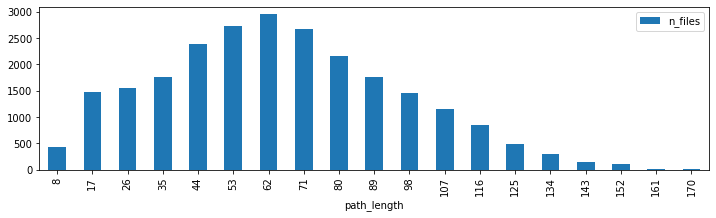

In [24]:
path_length = sa.func.length(File.path).label('path_length')

select_path_lengths = select([
        path_length, count().label('n_files'),
    ]).group_by(path_length).order_by(path_length)

_ = read_sql(select_path_lengths, index_col='path_length')

_.plot.bar(figsize=(12, 3))
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT _file.size AS file_size, count(*) AS n_files 
FROM _file GROUP BY _file.size ORDER BY file_size
()


,file_size
min,63.0
max,46148.0


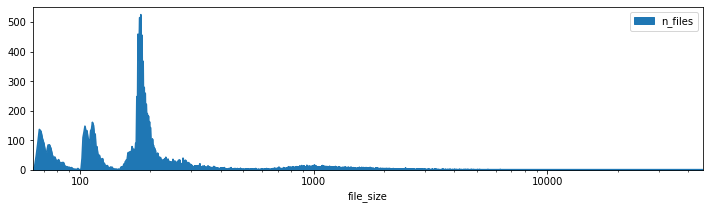

In [25]:
file_size = File.size.label('file_size')

select_file_sizes = select([
        file_size, count().label('n_files'),
    ]).group_by(file_size).order_by(file_size)

_ = read_sql(select_file_sizes, index_col='file_size')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT n_values, count(*) AS n_files 
FROM (SELECT _file.glottocode AS glottocode, count(*) AS n_values 
FROM _file JOIN _value ON _file.id = _value.file_id 
WHERE _value.line IN (?, ?) GROUP BY _file.glottocode) GROUP BY n_values ORDER BY n_values
(0, 1)


,n_values
min,2.0
max,36.0


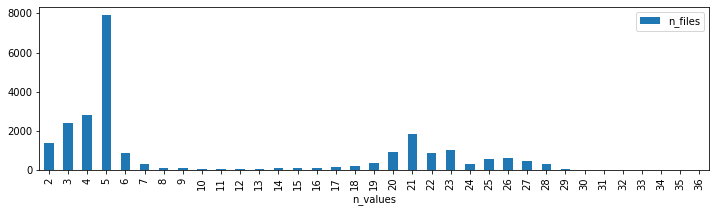

In [26]:
file_nvalues = select([
        File.glottocode, count().label('n_values'),
    ]).select_from(sa.join(File, Value))\
    .where(Value.line.in_((0, 1)))\
    .group_by(File.glottocode).c.n_values

select_nvalues = select([
        file_nvalues, count().label('n_files'),
    ]).group_by(file_nvalues).order_by(file_nvalues)

_ = read_sql(select_nvalues, index_col=['n_values'])

_.plot.bar(figsize=(12, 3))
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT length(_value.value) AS value_length, count(*) AS n_values 
FROM _value GROUP BY length(_value.value) ORDER BY value_length
()


,value_length
min,1.0
max,6215.0


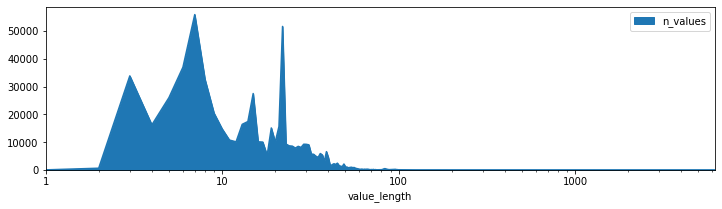

In [27]:
value_length = sa.func.length(Value.value).label('value_length')

select_value_length = select([
        value_length, count().label('n_values'),
    ]).group_by(value_length).order_by(value_length)

_ = read_sql(select_value_length, index_col='value_length')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [28]:
raw.print_stats()

SELECT _option.section, _option.option, count(*) AS n 
FROM _option JOIN _value ON _option.id = _value.option_id GROUP BY _option.section, _option.option ORDER BY _option.section, n DESC
()


altnames               multitree              54,664
altnames               hhbib_lgcode           27,099
altnames               lexvo                  26,031
altnames               elcat                  23,327
altnames               wals                   2,441
altnames               wals other             2,097
altnames               moseley & asher (1994) 2,089
altnames               ruhlen (1987)          2,007
altnames               glottolog              955
altnames               ethnologue             2
classification         subrefs                14,813
classification         sub                    11,462
classification         familyrefs             687
classification         family                 205
core                   level                  24,438
core                   name                   24,438
core                   links                  24,115
core                   macroareas             18,521
core                   countries              10,979
core       

In [29]:
#raw.print_fields()

## languoid

In [30]:
FAMILY, LANGUAGE, DIALECT = LEVEL = treedb.models.LEVEL

Languoid = treedb.Languoid

print_sql(Languoid)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid')
SELECT count(*) AS n_languoids 
FROM languoid
()


CREATE TABLE languoid (
	id VARCHAR(8) NOT NULL CHECK (length(id) = 8), 
	level VARCHAR(8) NOT NULL, 
	name VARCHAR NOT NULL CHECK (name != ''), 
	parent_id VARCHAR(8), 
	hid TEXT CHECK (length(hid) >= 3), 
	iso639_3 VARCHAR(3) CHECK (length(iso639_3) = 3), 
	latitude FLOAT CHECK (latitude BETWEEN -90 AND 90), 
	longitude FLOAT CHECK (longitude BETWEEN -180 AND 180), 
	PRIMARY KEY (id), 
	CHECK ((latitude IS NULL) = (longitude IS NULL)), 
	CHECK (level IN ('family', 'language', 'dialect')), 
	UNIQUE (name), 
	FOREIGN KEY(parent_id) REFERENCES languoid (id), 
	UNIQUE (hid), 
	UNIQUE (iso639_3)
)
24438


In [31]:
read_sql(select([Languoid]).limit(5), index_col='id')

SELECT languoid.id, languoid.level, languoid.name, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid
 LIMIT ? OFFSET ?
(5, 0)


,level,name,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
abin1243,language,Abinomn,None,bsa,bsa,-2.922810,138.891000
abis1238,language,Aewa,None,ash,ash,-1.284096,-75.084405
abkh1242,family,Abkhaz-Adyge,None,None,None,NaN,NaN
abkh1243,family,Abkhaz-Abaza,abkh1242,None,None,NaN,NaN
abaz1241,language,Abaza,abkh1243,abq,abq,41.121400,42.727300


In [32]:
read_sql(select([Languoid]).order_by(Languoid.id).limit(5), index_col='id')

SELECT languoid.id, languoid.level, languoid.name, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.id
 LIMIT ? OFFSET ?
(5, 0)


,level,name,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,dialect,3Ad-Tekles,nort3292,None,None,NaN,NaN
aala1237,dialect,Aalawa,ramo1244,None,None,NaN,NaN
aant1238,dialect,Aantantara,nort2920,None,None,NaN,NaN
aari1238,family,Aari-Gayil,ahkk1235,aiz,aiz,NaN,NaN
aari1239,language,Aari,aari1238,aiw,aiw,5.95034,36.5721


In [33]:
read_sql(select([Languoid]).order_by(Languoid.name).limit(5), index_col='id')

SELECT languoid.id, languoid.level, languoid.name, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.name
 LIMIT ? OFFSET ?
(5, 0)


,level,name,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
gang1269,dialect,!Gã!nge,sero1239,None,None,NaN,NaN
kwii1241,family,!Kwi,tuuu1241,None,None,NaN,NaN
oung1238,language,!O!ung,book1242,oun,oun,-15.3,14.35
abda1238,dialect,'Abd Al-Kuri,soqo1240,None,None,NaN,NaN
aden1242,dialect,'Aden,jude1267,None,None,NaN,NaN


In [34]:
Child, Parent = (sa.orm.aliased(Languoid, name=n) for n in ('child', 'parent'))

select_parent_levels = select([
        Child.level.label('child_level'),
        Parent.level.label('parent_level'),
        count().label('n_languoids'),
    ]).select_from(sa.outerjoin(Child, Parent, Child.parent_id == Parent.id))\
    .group_by(Child.level, Parent.level)\
    .order_by('child_level', 'parent_level')

read_sql(select_parent_levels, index_col=['child_level', 'parent_level'])\
    .unstack(fill_value=0).assign(all=lambda x: x.sum(axis='columns'))\
    .pipe(lambda x: x.append(x.sum().rename('all')))

SELECT child.level AS child_level, parent.level AS parent_level, count(*) AS n_languoids 
FROM languoid AS child LEFT OUTER JOIN languoid AS parent ON child.parent_id = parent.id GROUP BY child.level, parent.level ORDER BY child_level, parent_level
()


n_languoids                            all
parent_level         NaN dialect family language       
child_level                                            
dialect                0    1422      0    10133  11555
family               241       0   4148        0   4389
language             188       0   8306        0   8494
all                  429    1422  12454    10133  24438

In [35]:
select_nisos = select([
        Languoid.level.label('level'),
        count().label('n_languoids'),
        count(Languoid.iso639_3).label('n_isos'),
    ]).group_by(Languoid.level)\
    .order_by('level')

read_sql(select_nisos, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_isos'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.iso639_3) AS n_isos 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_isos,ratio
level,,,
dialect,11555,150,1.298139
family,4389,46,1.048075
language,8494,7807,91.911938


In [36]:
select_nlocations = select([
        Languoid.level.label('level'),
        count().label('n_languoids'),
        count(Languoid.latitude).label('n_locations'),
    ]).group_by(Languoid.level)\
    .order_by('level')

read_sql(select_nlocations, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_locations'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.latitude) AS n_locations 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_locations,ratio
level,,,
dialect,11555,193,1.670273
family,4389,15,0.341763
language,8494,7881,92.783141


SELECT languoid.latitude, languoid.longitude 
FROM languoid 
WHERE languoid.level = ?
('language',)


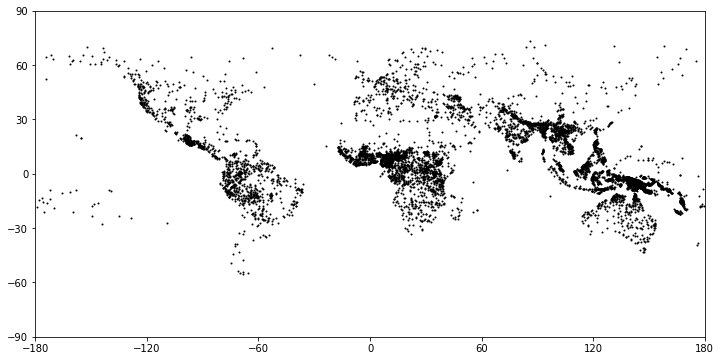

In [37]:
select_latlon = select([
        Languoid.latitude, Languoid.longitude
    ]).where(Languoid.level == LANGUAGE)

latitudes, longitudes = zip(*select_latlon.execute())
    
plt.figure(figsize=(12, 6))
plt.axis([-180, 180, -90, 90])
plt.xticks(range(-180, 181, 60))
plt.yticks(range(-90, 91, 30))
plt.scatter(longitudes, latitudes, 1, 'black');

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id 
HAVING count(child.id) >= ? ORDER BY n_languages
('family', 'language', 100)


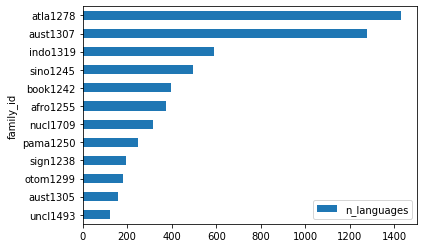

In [38]:
tree = treedb.Languoid.tree()

Family = sa.orm.aliased(treedb.Languoid, name='family')

n_languages = count(Child.id).label('n_languages')

select_family_nlanguages = select([
        Family.id.label('family_id'),
        n_languages,
    ]).select_from(sa.outerjoin(Family,
        sa.join(Child, tree, tree.c.child_id == Child.id),
        tree.c.parent_id == Family.id))\
    .where(Family.parent_id == None)\
    .where(Family.level == FAMILY)\
    .where(Child.level == LANGUAGE)\
    .group_by(Family.id)

select_top_families = select_family_nlanguages\
    .having(n_languages >= 100)\
    .order_by(n_languages)

read_sql(select_top_families, index_col=['family_id']).plot.barh();

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT n_languages AS family_size, count(*) AS n_families 
FROM (SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id) GROUP BY n_languages ORDER BY family_size
('family', 'language')


,family_size
min,2.0
max,1432.0


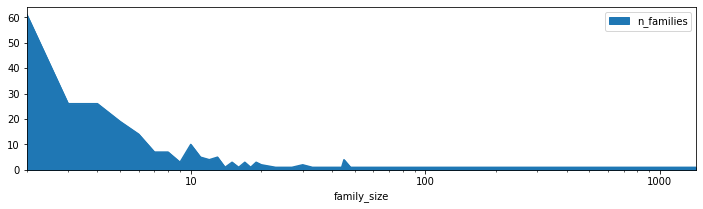

In [39]:
family_size = select_family_nlanguages.c.n_languages.label('family_size')

select_family_sizes = select([
        family_size, count().label('n_families'),
    ]).group_by(family_size).order_by(family_size)

_ = read_sql(select_family_sizes, index_col=['family_size'])

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [40]:
levels = sa.union_all(*
        (select([sa.literal(l).label('level')]) for l in LEVEL)
    ).cte(name='levels')

select_nchildren = select([
        Parent.id.label('parent_id'),
        Parent.level.label('parent_level'),
        levels.c.level.label('child_level'),
        count(Child.id).label('n_children'),
    ]).select_from(
        sa.join(Parent, levels, sa.true())
        .outerjoin(Child, sa.and_(
            Child.parent_id == Parent.id, Child.level == levels.c.level)))\
    .group_by(Parent.id, Parent.level, levels.c.level)

read_sql(select_nchildren)\
    .pivot_table(index='parent_level', columns='child_level', values='n_children',
                 aggfunc=['sum', 'max', 'mean'], fill_value=0)

WITH levels AS 
(SELECT ? AS level UNION ALL SELECT ? AS level UNION ALL SELECT ? AS level)
 SELECT parent.id AS parent_id, parent.level AS parent_level, levels.level AS child_level, count(child.id) AS n_children 
FROM languoid AS parent JOIN levels ON 1 LEFT OUTER JOIN languoid AS child ON child.parent_id = parent.id AND child.level = levels.level GROUP BY parent.id, parent.level, levels.level
('family', 'language', 'dialect')


sum                     max                      mean  \
child_level  dialect family language dialect family language   dialect   
parent_level                                                             
dialect         1422      0        0      22      0        0  0.123064   
family             0   4148     8306       0     44      399  0.000000   
language       10133      0        0      32      0        0  1.192960   

                                 
child_level    family  language  
parent_level                     
dialect       0.00000  0.000000  
family        0.94509  1.892458  
language      0.00000  0.000000

In [41]:
select_ndescendants = select([
        Parent.id.label('parent_id'),
        Parent.level.label('parent_level'),
        count(Child.id).label('n_descendants'),
    ]).select_from(
        sa.join(Child, tree, tree.c.child_id == Child.id)
        .join(Parent, tree.c.parent_id == Parent.id))\
    .group_by(Parent.id, Parent.level)\
    .alias()

n_descendants = select_ndescendants.c.n_descendants
d_min = sa.func.min(n_descendants).label('min')
d_max = sa.func.max(n_descendants).label('max')
d_mean = (sa.func.sum(n_descendants).cast(sa.Float) / count(n_descendants)).label('mean')

select_level_mean_descendants = select([
        select_ndescendants.c.parent_level,
        d_min, d_max, d_mean,
    ]).group_by(select_nchildren.c.parent_level).order_by(select_nchildren.c.parent_level)

select_total_mean_descendants = select([
        sa.literal('total').label('parent_level'),
        d_min, d_max, d_mean,
    ])

select_mean_descendants = [select_level_mean_descendants, select_total_mean_descendants]

_ = pd.concat([read_sql(q, index_col=['parent_level']) for q in select_mean_descendants])
_.columns = pd.MultiIndex.from_product([['n_descendants'], _.columns])
_

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id 
WHERE parent.parent_id IS NOT NULL)
 SELECT anon_1.parent_level, min(anon_1.n_descendants) AS min, max(anon_1.n_descendants) AS max, CAST(sum(anon_1.n_descendants) AS FLOAT) / count(anon_1.n_descendants) AS mean 
FROM (SELECT parent.id AS parent_id, parent.level AS parent_level, count(child.id) AS n_descendants 
FROM languoid AS child JOIN tree ON tree.child_id = child.id JOIN languoid AS parent ON tree.parent_id = parent.id GROUP BY parent.id, parent.level) AS anon_1 GROUP BY parent_level ORDER BY parent_level
()
WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, child.parent_id AS parent_id 
FROM languoid AS child 
WHERE child.parent_id IS NOT NULL UNION ALL SELE

n_descendants                 
                       min   max       mean
parent_level                               
dialect                  1    57   4.887290
family                   1  4711  32.279335
language                 1   125   4.153487
total                    1  4711  20.462177

## link

In [42]:
Link = treedb.models.Link

print_sql(Link)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'link')
SELECT count(*) AS n_links 
FROM link
()


CREATE TABLE link (
	languoid_id VARCHAR(8) NOT NULL, 
	ord INTEGER NOT NULL CHECK (ord >= 1), 
	url TEXT NOT NULL CHECK (url != ''), 
	title TEXT CHECK (title != ''), 
	scheme TEXT, 
	PRIMARY KEY (languoid_id, ord), 
	UNIQUE (languoid_id, url), 
	CHECK (substr(url, 1, length(scheme) + 3) = scheme || '://'), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (scheme IN ('http', 'https'))
)
24115


SELECT link.scheme AS link_scheme, count(*) AS n_links 
FROM link GROUP BY link.scheme ORDER BY link_scheme
()


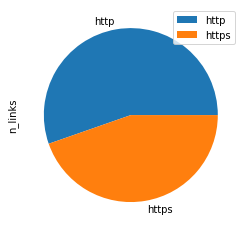

In [43]:
select_scheme_nlinks = select([
        Link.scheme.label('link_scheme'), count().label('n_links'),
    ]).group_by(Link.scheme).order_by('link_scheme')

read_sql(select_scheme_nlinks, index_col=['link_scheme']).plot.pie(y='n_links');

SELECT link.url 
FROM link
()


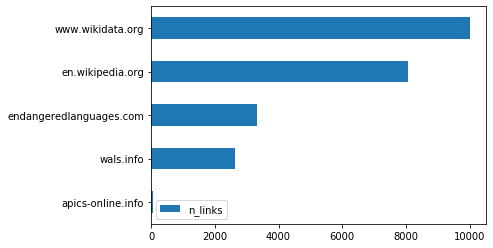

In [44]:
hosts = collections.Counter(urlparse(u).hostname for u, in select([Link.url]).execute())

pd.DataFrame.from_dict(hosts, orient='index', columns=['n_links'])\
    .sort_values(by='n_links').plot.barh();

## denormalized

In [45]:
#read_sql(treedb.get_query())